In [1]:
import gc
import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from collections import defaultdict

# Customer Retention
To understand if their products are selling well, and understand if their customers enjoyed the product they bought from you enough to make a repeated purchase. 
1) Customer retention rates
2) The average quantity purchased 
3) The average price by segmenting them into cohorts

In [2]:
online = pd.read_csv('./data.csv', encoding = "ISO-8859-1")

# -- Convert InvoiceDate from object to datetime format
online['InvoiceDate'] = pd.to_datetime(online['InvoiceDate'])
online.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


### Group customer acquisition cohorts based on the month they made their first purchase. 

In [3]:
# create a function to truncate given data in column to a first day of the month
def get_month(x):
    return dt.datetime(x.year, x.month, 1) # returning the first day of the month

# apply function to invoice date to invoice month column
online['InvoiceMonth'] = online['InvoiceDate'].apply(get_month)
grouping1 = online.groupby('CustomerID')['InvoiceMonth']
# determine the first purchase month for each customer  
online['CohortMonth'] = grouping1.transform('min') # extracts the minimum value from each group
online = online.dropna(subset=['CustomerID'])

print(online.describe())

            Quantity                    InvoiceDate      UnitPrice  \
count  406829.000000                         406829  406829.000000   
mean       12.061303  2011-07-10 16:30:57.879207424       3.460471   
min    -80995.000000            2010-12-01 08:26:00       0.000000   
25%         2.000000            2011-04-06 15:02:00       1.250000   
50%         5.000000            2011-07-31 11:48:00       1.950000   
75%        12.000000            2011-10-20 13:06:00       3.750000   
max     80995.000000            2011-12-09 12:50:00   38970.000000   
std       248.693370                            NaN      69.315162   

          CustomerID                   InvoiceMonth  \
count  406829.000000                         406829   
mean    15287.690570  2011-06-26 02:24:17.648299520   
min     12346.000000            2010-12-01 00:00:00   
25%     13953.000000            2011-04-01 00:00:00   
50%     15152.000000            2011-07-01 00:00:00   
75%     16791.000000            2011-10

### Create our cohort Index columns

In [4]:
# Calculate the date difference between the first transaction and the next avtivity. 
def get_date_int(df, column):
    year = df[column].dt.year
    month = df[column].dt.month
    day = df[column].dt.day
    return year, month, day

In [5]:
invoice_year, invoice_month, _ = get_date_int(online, 'InvoiceMonth')
cohort_year, cohort_month, _ = get_date_int(online, 'CohortMonth')

In [6]:
# Get the vaslue of the year and month difference between the transactions
years_diff = invoice_year - cohort_year
months_diff = invoice_month - cohort_month 

In [7]:
# build the cohort index based on the number of months since the first trtansaction
online['CohortIndex'] = years_diff * 12 + months_diff + 1
online.head()

C:\Users\wangc\AppData\Local\Temp\ipykernel_9848\1162362574.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  online['CohortIndex'] = years_diff * 12 + months_diff + 1


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceMonth,CohortMonth,CohortIndex
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,2010-12-01,2010-12-01,1
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12-01,2010-12-01,1
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,2010-12-01,2010-12-01,1
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12-01,2010-12-01,1
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12-01,2010-12-01,1


In [8]:
# Count monthly active customers from each cohort which went on to make a subsequent purchase at a later month
grouping_count = online.groupby(['CohortMonth', 'CohortIndex'])
cohort_data = grouping_count['CustomerID'].apply(pd.Series.nunique)
cohort_data = cohort_data.reset_index()
cohort_counts = cohort_data.pivot(index = 'CohortMonth',
                                  columns = 'CohortIndex',
                                  values = 'CustomerID')
print(cohort_counts.head())

CohortIndex     1      2      3      4      5      6      7      8      9   \
CohortMonth                                                                  
2010-12-01   948.0  362.0  317.0  367.0  341.0  376.0  360.0  336.0  336.0   
2011-01-01   421.0  101.0  119.0  102.0  138.0  126.0  110.0  108.0  131.0   
2011-02-01   380.0   94.0   73.0  106.0  102.0   94.0   97.0  107.0   98.0   
2011-03-01   440.0   84.0  112.0   96.0  102.0   78.0  116.0  105.0  127.0   
2011-04-01   299.0   68.0   66.0   63.0   62.0   71.0   69.0   78.0   25.0   

CohortIndex     10     11     12     13  
CohortMonth                              
2010-12-01   374.0  354.0  474.0  260.0  
2011-01-01   146.0  155.0   63.0    NaN  
2011-02-01   119.0   35.0    NaN    NaN  
2011-03-01    39.0    NaN    NaN    NaN  
2011-04-01     NaN    NaN    NaN    NaN  


In [9]:
# get the customers retained each month as a percentage of the total size of the cohort by month
cohort_sizes = cohort_counts.iloc[:,0]
retention = cohort_counts.divide(cohort_sizes, axis=0)
retention.round(3) * 100
retention.index = retention.index.strftime('%m-%Y')

In [10]:
retention

CohortIndex,1,2,3,4,5,6,7,8,9,10,11,12,13
CohortMonth,,,,,,,,,,,,,
12-2010,1.0,0.381857,0.334388,0.387131,0.359705,0.396624,0.379747,0.354430,0.354430,0.394515,0.373418,0.500000,0.274262
01-2011,1.0,0.239905,0.282660,0.242280,0.327791,0.299287,0.261283,0.256532,0.311164,0.346793,0.368171,0.149644,NaN
02-2011,1.0,0.247368,0.192105,0.278947,0.268421,0.247368,0.255263,0.281579,0.257895,0.313158,0.092105,NaN,NaN
03-2011,1.0,0.190909,0.254545,0.218182,0.231818,0.177273,0.263636,0.238636,0.288636,0.088636,NaN,NaN,NaN
04-2011,1.0,0.227425,0.220736,0.210702,0.207358,0.237458,0.230769,0.260870,0.083612,NaN,NaN,NaN,NaN
05-2011,1.0,0.236559,0.172043,0.172043,0.215054,0.243728,0.265233,0.103943,NaN,NaN,NaN,NaN,NaN
06-2011,1.0,0.208511,0.187234,0.272340,0.246809,0.336170,0.102128,NaN,NaN,NaN,NaN,NaN,NaN
07-2011,1.0,0.209424,0.204188,0.230366,0.272251,0.115183,NaN,NaN,NaN,NaN,NaN,NaN,NaN
08-2011,1.0,0.251497,0.251497,0.251497,0.137725,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Visualiza the result

In [11]:
# Calculate Average Quantity 
grouping_qty = online.groupby(['CohortMonth', 'CohortIndex'])
cohort_data_qty = grouping_qty['Quantity'].mean()
cohort_data_qty = cohort_data_qty.reset_index()
average_quantity = cohort_data_qty.pivot(index='CohortMonth',
                                         columns='CohortIndex',
                                         values='Quantity')
average_quantity.index = average_quantity.index.strftime('%m-%Y')

In [12]:
average_quantity

CohortIndex,1,2,3,4,5,6,7,8,9,10,11,12,13
CohortMonth,,,,,,,,,,,,,
12-2010,11.037691,14.603253,14.982141,14.801090,12.943024,14.318095,15.173387,14.759559,16.660455,16.691004,17.264954,12.823263,14.776623
01-2011,10.015502,12.573579,12.343099,10.940531,12.234048,14.895373,14.226042,14.385729,11.398390,9.883069,9.090436,9.541612,NaN
02-2011,10.830223,12.081317,18.563242,11.959050,11.117223,11.411479,13.346939,12.381845,10.272146,11.945771,12.645977,NaN,NaN
03-2011,9.762443,9.924222,12.207366,9.455425,13.579228,12.313412,13.162317,12.177130,10.517494,8.880203,NaN,NaN,NaN
04-2011,9.753962,10.105226,9.420617,11.598922,11.488889,8.220785,9.680620,9.289391,7.290019,NaN,NaN,NaN,NaN
05-2011,10.866930,9.030276,13.884270,11.805435,10.900268,8.668230,10.148510,7.371571,NaN,NaN,NaN,NaN,NaN
06-2011,10.327849,13.681576,10.463847,13.275611,10.232734,9.758786,9.255627,NaN,NaN,NaN,NaN,NaN,NaN
07-2011,9.722333,12.700952,7.142646,7.844268,6.013594,7.013233,NaN,NaN,NaN,NaN,NaN,NaN,NaN
08-2011,9.890294,5.958955,5.345404,5.976259,6.980110,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [13]:
# Calculate Average Price
grouping_price = online.groupby(['CohortMonth', 'CohortIndex'])
cohort_data_price = grouping_price['UnitPrice'].mean()
cohort_data_price = cohort_data_price.reset_index()
average_price = cohort_data_price.pivot(index='CohortMonth',
                                     columns='CohortIndex',
                                     values='UnitPrice')
average_price.index = average_price.index.strftime('%m-%Y')

In [14]:
average_price

CohortIndex,1,2,3,4,5,6,7,8,9,10,11,12,13
CohortMonth,,,,,,,,,,,,,
12-2010,3.205109,3.183116,3.203559,3.587192,2.931327,4.969632,3.180149,3.222388,3.504112,3.033842,3.298406,2.826403,2.758445
01-2011,3.496222,3.650142,3.061950,8.366407,3.156226,3.161185,2.911392,2.745126,2.641303,5.452754,2.874456,2.603719,NaN
02-2011,3.343196,4.449731,4.796154,3.147080,2.987471,2.788575,2.808957,3.209261,2.890596,2.938377,3.217126,NaN,NaN
03-2011,3.292194,4.975156,3.662518,3.280997,3.609860,2.760767,2.838699,2.794577,2.697759,2.486305,NaN,NaN,NaN
04-2011,3.422758,3.960941,3.305169,2.677791,3.017785,2.860244,2.890191,2.800054,2.613616,NaN,NaN,NaN,NaN
05-2011,4.636680,3.234354,2.647258,3.167391,2.655884,2.488606,2.614666,2.542818,NaN,NaN,NaN,NaN,NaN
06-2011,10.399197,3.178243,3.340709,2.828090,2.561434,3.522604,2.285547,NaN,NaN,NaN,NaN,NaN,NaN
07-2011,4.463802,3.480495,2.746260,2.693244,2.404676,2.367032,NaN,NaN,NaN,NaN,NaN,NaN,NaN
08-2011,3.023762,5.404160,5.691347,7.041680,6.830066,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


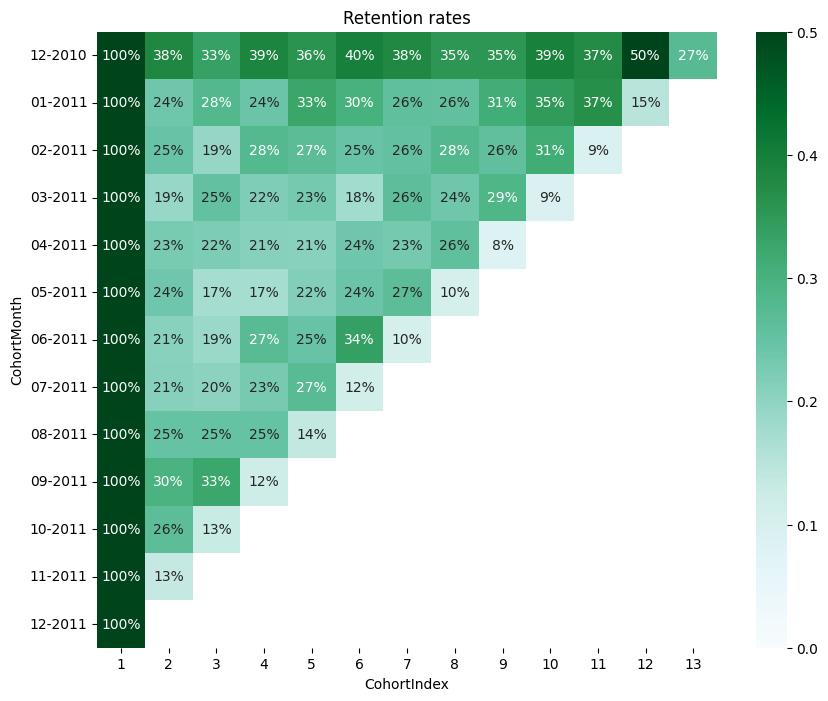

In [15]:
# Plot retention rates
plt.figure(figsize=(10, 8))
plt.title('Retention rates')
sns.heatmap(data = retention, annot = True, fmt = '.0%',vmin = 0.0,vmax = 0.5,cmap = 'BuGn')
plt.show()

Note that the first column will always be 100% as it the total size of each cohort month. The distinct diagonal shape of the cohort heatmap shows that at the time of the data download (Dec 2011), only the first cohort (Dec 2010) would have had be able to make a purchase in their 13th month since their first transaction. This logic extends through to the rest of the cohorts. Notice in our Dec 2010 cohort, there is a spike in the our retention rate (50%). This could potentially indicate the *seasonal shopping* crowd.



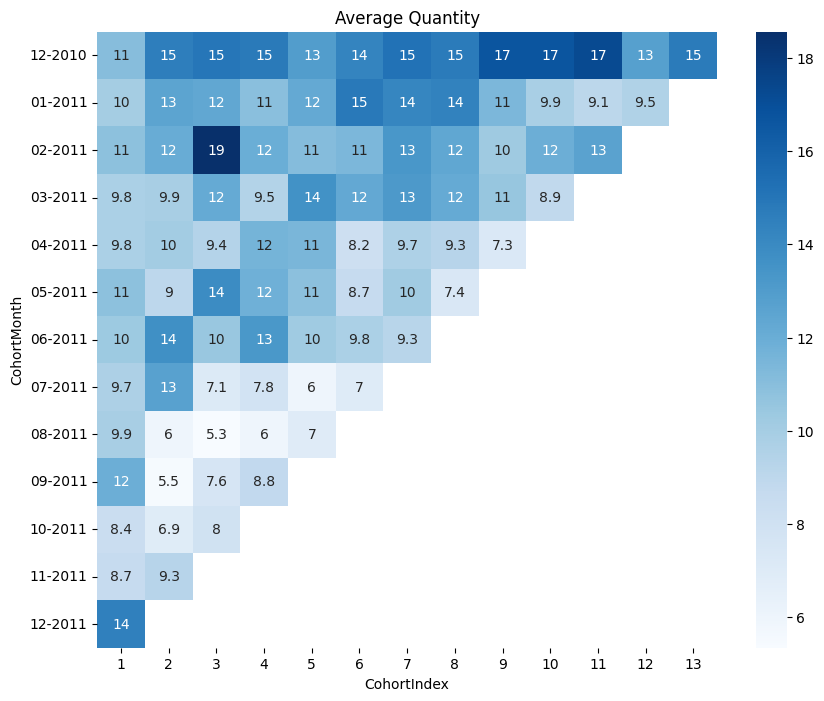

In [16]:
# Plot average quantity
plt.figure(figsize=(10, 8))
plt.title('Average Quantity')
sns.heatmap(data = average_quantity, annot=True, cmap='Blues')
plt.show()

Here, we can observe the average quantity of our cohorts. Interestingly, the customers that are retained in subsequent months purchase more products from the online store. That’s a good sign!

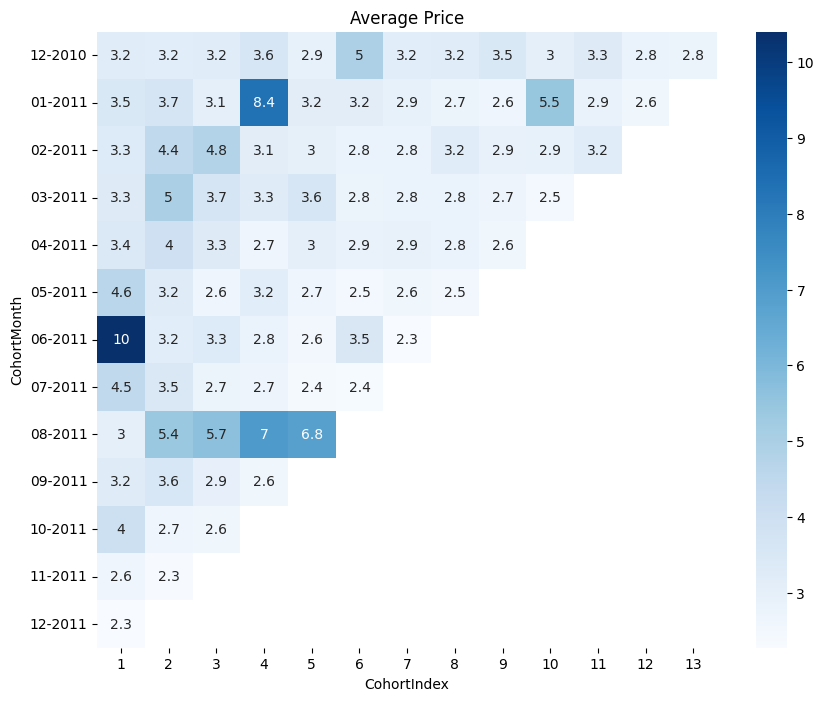

In [17]:
# Plot average price
plt.figure(figsize=(10, 8))
plt.title('Average Price')
sns.heatmap(data = average_price, annot=True, cmap='Blues')
plt.show()

While the average price of items purchased remains consistent or even becoming lower, there are some anomalies in our heatmap that are worth exploring. Could it be a particular marketing campaign launched during that period that sold higher priced products to our customers? If so, we should invest more in those campaigns!